In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
from tqdm import tqdm

def feature_extraction(data_path):
    """Parses audio files in supplied data path.
    -*- author: mtobeiyf https://github.com/mtobeiyf/audio-classification -*-
    """
    r = os.listdir(data_path)
    r.sort()
    features, labels = parse_audio_files(data_path, r)
    return features, labels

def extract_feature(file_name):
    """Generates feature input (mfccs, chroma, mel, contrast, tonnetz).
    -*- author: mtobeiyf https://github.com/mtobeiyf/audio-classification -*-
    """
    X, sample_rate = sf.read(file_name, dtype='float32')
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
    X = np.asfortranarray(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    # tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs, chroma, mel, contrast

def parse_audio_files(parent_dir, sub_dirs, file_ext=None, verbose=True):
    """Parses directory in search of specified file types, then compiles feature data from them.
    -*- adapted from code by mtobeiyf https://github.com/mtobeiyf/audio-classification -*-
    """
    # by default test for only these types
    if file_ext == None:
        file_types = ['*.ogg', '*.wav']
    else:
        file_types = []
        file_types.push(file_ext)
    features, labels = np.empty((0,187)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for file_ext in file_types:
            # file names
            iter = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))
            if len(iter) > 0:
                if verbose: print('Reading', os.path.join(parent_dir, sub_dir, file_ext), '...')
                for fn in tqdm(iter):
                    ext_features = get_ext_features(fn)
                    if type(ext_features) is np.ndarray:
                        features = np.vstack([features, ext_features])
                        labels = np.append(labels, label)
    return np.array(features), np.array(labels, dtype = np.int)

def get_ext_features(fn):
    """Returns features for individual audio file.
    -*- adapted from code by mtobeiyf https://github.com/mtobeiyf/audio-classification -*-
    """
    try:
        mfccs, chroma, mel, contrast = extract_feature(fn)
        ext_features = np.hstack([mfccs, chroma, mel, contrast])
        return ext_features
    except Exception as e:
        print("[Error] extract feature error. %s" % (e))
        return None

def parse_audio_file(fn):
    """Returns features of single audio file
    -*- adapted from code by mtobeiyf https://github.com/mtobeiyf/audio-classification -*-
    """
    features = np.empty((0,187))
    ext_features = get_ext_features(fn)
    features = np.vstack([features,ext_features])
    return np.array(features)


In [2]:
# from pyaudioclassification import feature_extraction, train, predict, print_leaderboard
features_train, labels_train = feature_extraction('../augmented_data/train')
features_test, labels_test = feature_extraction('../augmented_data/test')

100%|██████████| 278/278 [00:02<00:00, 118.85it/s]


In [3]:
import numpy as np
np.save('%s.npy' % 'features_train', features_train)
np.save('%s.npy' % 'labels_train', labels_train)
np.save('%s.npy' % 'features_test', features_test)
np.save('%s.npy' % 'labels_test', labels_test)

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

In [5]:
features_train = np.load('%s.npy' % 'features_train')
labels_train = np.load('%s.npy' % 'labels_train')
features_test = np.load('%s.npy' % 'features_test')
labels_test = np.load('%s.npy' % 'labels_test')

In [13]:
x = np.expand_dims(features_train, axis=2)
print(x.shape, labels_train)

x_test = np.expand_dims(features_test, axis=2)
print(x_test.shape, labels_test)

(2220, 187, 1) [0 0 0 ... 1 1 1]
(546, 187, 1) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [17]:
model = models.Sequential()
model.add(layers.Conv1D(64, 3, input_shape=(187, 1)))
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(64, 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(128, 3))
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 3))
model.add(layers.Activation('relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 185, 64)           256       
_________________________________________________________________
activation_5 (Activation)    (None, 185, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 183, 64)           12352     
_________________________________________________________________
activation_6 (Activation)    (None, 183, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 59, 128)           24704     
_________________________________________________________________
activation_7 (Activation)    (None, 59, 128)          

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x, labels_train, batch_size=64, epochs=50, verbose=True, validation_split=0.2)

Epoch 1/50
28/28 [==============================] - 0s 17ms/step - loss: 0.4392 - accuracy: 0.7545 - val_loss: 0.2188 - val_accuracy: 0.9730
Epoch 2/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0589 - accuracy: 0.9837 - val_loss: 0.1166 - val_accuracy: 0.9932
Epoch 3/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0578 - val_accuracy: 0.9955
Epoch 4/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0229 - accuracy: 0.9927 - val_loss: 0.0159 - val_accuracy: 0.9977
Epoch 5/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0048 - val_accuracy: 0.9977
Epoch 6/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.0816 - val_accuracy: 0.9955
Epoch 7/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 1.3750e-04 - val_accuracy: 1.0000
Epoch 8/5

In [20]:
from keras.models import load_model

model.save('less_features.h5')
model = load_model('less_features.h5')

In [21]:
preds = model.predict(np.expand_dims(features_test, axis=2))
preds.shape, labels_test.shape

((546, 1), (546,))

In [22]:
np.expand_dims(features_test, axis=2)[0, :, :].shape

(187, 1)

In [23]:
model.predict(np.expand_dims(np.expand_dims(features_test, axis=2)[0, :, :], axis=0))

array([[8.065618e-11]], dtype=float32)

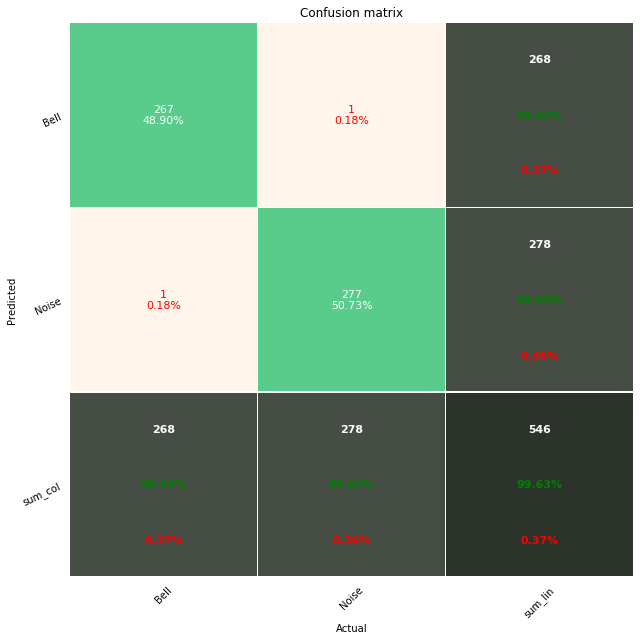

In [24]:
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data
plot_confusion_matrix_from_data(labels_test, np.round(preds), columns=['Bell', 'Noise'])

In [25]:
import shutil

In [38]:
data_dir = "../augmented_data/test/noise"
for filename in os.listdir(data_dir):
    ext_features = get_ext_features(os.path.join(data_dir, filename))
    feat = np.expand_dims(np.expand_dims(ext_features, axis=0), axis=2)
    pred = model.predict(feat)
    print(f'testing {filename}: {pred[0][0]}')
    if round(pred[0][0]) < 0.5:
        print(f'Wrong for {filename}: {pred}!')
        shutil.copyfile(os.path.join(data_dir, filename), os.path.join('../wrong_data_cnn', filename))

testing 0.wav: 0.9999992251396179
testing 1.wav: 0.999996542930603
testing 10.wav: 0.9999995231628418
testing 100.wav: 1.0
testing 101.wav: 0.9999995231628418
testing 102.wav: 1.0
testing 103.wav: 1.0
testing 104.wav: 0.9999969005584717
testing 105.wav: 0.9999940395355225
testing 106.wav: 1.0
testing 107.wav: 0.9999985694885254
testing 108.wav: 1.0
testing 109.wav: 0.9999991655349731
testing 11.wav: 1.0
testing 110.wav: 0.9999992251396179
testing 111.wav: 1.0
testing 112.wav: 0.9999997615814209
testing 113.wav: 0.9999993443489075
testing 114.wav: 1.0
testing 115.wav: 1.0
testing 270.wav: 1.0
testing 271.wav: 0.9999997615814209
testing 272.wav: 1.0
testing 273.wav: 1.0
testing 274.wav: 1.0
testing 275.wav: 1.0
testing 276.wav: 1.0
testing 277.wav: 1.0
testing 28.wav: 0.9999991655349731
testing 29.wav: 1.0
testing 3.wav: 0.9999997019767761
testing 30.wav: 0.9999978542327881
testing 31.wav: 1.0
testing 32.wav: 0.9999987483024597
testing 33.wav: 1.0
testing 34.wav: 0.9999997615814209
testi

In [39]:
data_dir = "../augmented_data/test/bell"
for filename in os.listdir(data_dir):
    ext_features = get_ext_features(os.path.join(data_dir, filename))
    feat = np.expand_dims(np.expand_dims(ext_features, axis=0), axis=2)
    pred = model.predict(feat)
    print(f'testing {filename}: {pred[0][0]}')
    if round(pred[0][0]) >= 0.5:
        print(f'Wrong for {filename}: {pred}!')
        shutil.copyfile(os.path.join(data_dir, filename), os.path.join('../wrong_data_cnn', filename))


testing 102.wav: 1.7660959500398477e-11
Wrong for 102.wav: [[1.766096e-11]]!
testing 103.wav: 8.142750362871709e-11
Wrong for 103.wav: [[8.1427504e-11]]!
testing 104.wav: 8.117749672464925e-08
Wrong for 104.wav: [[8.11775e-08]]!
testing 105.wav: 2.3077813965377558e-11
Wrong for 105.wav: [[2.3077814e-11]]!
testing 106.wav: 2.999007726184333e-12
Wrong for 106.wav: [[2.9990077e-12]]!
testing 107.wav: 0.00033351778984069824
Wrong for 107.wav: [[0.00033352]]!
testing 108.wav: 1.761122803145554e-09
Wrong for 108.wav: [[1.7611228e-09]]!
testing 109.wav: 8.11321773652729e-11
Wrong for 109.wav: [[8.113218e-11]]!
testing 11.wav: 1.8109433397306418e-10
Wrong for 11.wav: [[1.8109433e-10]]!
testing 110.wav: 5.7589154799086995e-12
Wrong for 110.wav: [[5.7589155e-12]]!
testing 111.wav: 1.1664441634806622e-10
Wrong for 111.wav: [[1.1664442e-10]]!
testing 112.wav: 1.4084989684998162e-13
Wrong for 112.wav: [[1.408499e-13]]!
testing 113.wav: 3.0059990052677676e-09
Wrong for 113.wav: [[3.005999e-09]]!
te

In [66]:
data_dir = "../augmented_data/test/bell"
for filename in os.listdir(data_dir):
    feat = feature_extraction()
    pred = predict(model, os.path.join(data_dir, filename))
    print(f'testing {filename}: {pred[0][0]}')
    if round(pred[0][0]) == 1:
        print(f'Wrong for {filename}')
        shutil.copyfile(os.path.join(data_dir, filename), os.path.join('../wrong_data_cnn', filename))

testing 0.wav: 9.199225701195246e-07
testing 1.wav: 7.1541359503157764e-09
testing 10.wav: 1.3524467101788673e-09
testing 100.wav: 1.3293525569224585e-07
testing 101.wav: 1.1438078928449613e-08
testing 102.wav: 4.2975031533387664e-08
testing 103.wav: 4.1524427274453046e-07
testing 104.wav: 0.0007772445678710938
testing 105.wav: 1.0416401607926673e-07
testing 106.wav: 4.6637659067982895e-08
testing 107.wav: 0.6068317294120789
Wrong for 107.wav
testing 108.wav: 7.072889275150374e-06
testing 109.wav: 4.588858644183347e-07
testing 11.wav: 1.487482336415269e-06
testing 110.wav: 9.11521436108842e-09
testing 111.wav: 8.404916798099293e-07
testing 112.wav: 1.0445602605102522e-08
testing 113.wav: 3.20610124617815e-05
testing 114.wav: 1.1921002851522644e-07
testing 115.wav: 1.0113253665622324e-06
testing 28.wav: 4.435746063791157e-07
testing 29.wav: 1.4250518631797604e-07
testing 3.wav: 0.00036144256591796875
testing 30.wav: 3.2454128813697025e-05
testing 31.wav: 2.707981838767637e-09
testing 32

In [27]:
tf.saved_model.save(model, 'bell_model_faster')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: bell_model_faster/assets


In [28]:
import tensorflow as tf



converter = tf.lite.TFLiteConverter.from_saved_model('bell_model_faster')
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

open("bell_model_187.tflite", "wb").write(tflite_model)

355476

In [30]:
import tensorflow as tf
import random

num_calibration_steps = 100
converter = tf.lite.TFLiteConverter.from_saved_model('bell_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        i = random.randint(0, features_test.shape[0])
        inpt = np.expand_dims(np.expand_dims(features_test, axis=2)[i, :, :], axis=0)
        # Get sample input data as a numpy array in a method of your choosing.
        yield inpt
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()

RuntimeError: tensorflow/lite/kernels/conv.cc:313 input->dims->size != 4 (3 != 4)Node number 1 (CONV_2D) failed to prepare.


In [88]:
np.expand_dims(np.expand_dims(features_test, axis=2)[0, :, :], axis=0).shape

(1, 187, 1)

In [39]:
import librosa

In [42]:
X , sr = librosa.load('../augmented_data/test/bell/0.wav')

In [60]:
%%timeit
# %time
stft = np.abs(librosa.stft(X))

466 µs ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
%%timeit
# %time
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)

2.4 ms ± 9.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
# %%timeit
%time
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 18.6 µs


In [62]:
%%timeit
# %time
mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)

2.31 ms ± 7.32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
%%timeit
# %time
contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)

1.07 ms ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
%%timeit
# %time
tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr).T,axis=0)

105 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%%timeit
# %time
ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])

ext_features = np.expand_dims(ext_features, axis=0)
ext_features = np.expand_dims(ext_features, axis=2)
ext_features = ext_features.astype(np.float32)

14.9 µs ± 99.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
